# Marginal Structural Models  
## Meghan Broadbent

In [2]:
setwd("/Users/meg/Desktop/")

install.packages("sas7bdat") #to read in SAS data
library("sas7bdat")
install.packages("data.table") #to set large SAS data in table
library("data.table")
install.packages("ipw") #ipw package for MSM
library(ipw)
install.packages("ggplot2") #plotting
library(ggplot2)
install.packages("survival") #survival functions/plots
library(survival)
install.packages("dplyr") #working with objects/df
library(dplyr)
require(gridExtra)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Read in SAS data set

In [3]:
dfs = setDT(read.sas7bdat("msm_hiv_final.sas7bdat"))
#head(dfs)
#tail(dfs)
#colnames(dfs)

In [3]:
#to pull in a sas dataset, i had to use a data.table
#data.table handles large data better than a data.frame
#have to convert to a data.frame in order to plot
dfs = as.data.frame.matrix(dfs)
colnames(dfs)

[1] "id"          "month"       "aidsordeath" "haart"       "riskgroup"  
 [6] "bevent"      "cd4grp"      "Cd42"        "Cd43"        "Cd44"       
[11] "Cd45"        "Cd46"        "Cd47"        "rnagrp"      "Rna1"       
[16] "Rna2"        "Rna3"        "Rna4"        "LCd42"       "LCd43"      
[21] "LCd44"       "LCd45"       "LCd46"       "LCd47"       "LRna1"      
[26] "LRna2"       "LRna3"       "LRna4"       "laghaart"    "agegrp"     
[31] "Agegrp15"    "Agegrp30"    "Agegrp40"    "Year1"       "Year2"      
[36] "Year3"       "Year4"       "Year5"       "Year7"       "Year8"      
[41] "last"        "BCd42"       "BCd43"       "BCd44"       "BCd45"      
[46] "BCd46"       "BCd47"       "BRna1"       "BRna2"       "BRna3"      
[51] "BRna4"       "Bbevent"     "obstime"     "Group2"      "Group3"     
[56] "Group4"      "timespl1"    "timespl2"    "timespl3"    "onset_m"    
[61] "X_merge"     "cens"        "cens0"       "inter_Rna1"  "inter_Rna2" 
[66] "inter_Rna3"  "inter_Rna4"

### Create additional variables

In [4]:
#censoring variables
dfs$cens = dfs$aidsordeath
dfs$cens[is.na(dfs$aidsordeath)] = 1
dfs$cens[dfs$aidsordeath==1] = 0
dfs$cens0 = 0
dfs$cens0[dfs$cens==0] = 1

#offset a new variable for month, needed for the ipw package
dfs$mstart = dfs$month - 1

#check the missing data
#colSums(is.na(dfs))

In [124]:
#risk group is NOT an EMM
table(dfs$aidsordeath, dfs$haart)
table(dfs$aidsordeath[dfs$riskgroup==1], dfs$haart[dfs$riskgroup==1])
table(dfs$aidsordeath[dfs$riskgroup==2], dfs$haart[dfs$riskgroup==2])
table(dfs$aidsordeath[dfs$riskgroup==3], dfs$haart[dfs$riskgroup==3])
table(dfs$aidsordeath[dfs$riskgroup==4], dfs$haart[dfs$riskgroup==4])

   
        0     1
  0 38553 21778
  1   116    42

   
       0    1
  0 9420 6530
  1   30    7

   
        0     1
  0 13912  7535
  1    30    12

   
        0     1
  0 14242  6700
  1    52    22

   
       0    1
  0  979 1013
  1    4    1

The IPTW model for HAART initiation will follow  
$\begin{align}
\dfrac{\prod_k \mathbb{P}[A_k = a_{(k)} \mid B_k, V=v_k]}{\prod_k \mathbb{P}[A_k = a_{(k)} \mid B_k, \bar{L}_k = l_k, V=v_k]}
\end{align}$  
  
    
Whereas the IPTW model for censoring will follow  
$\begin{align}
\dfrac{\prod_k \mathbb{P}[C_k = c_{(k)} \mid B_k, \bar{A}_{k-1} = a_{k-1}, V=v_k]}{\prod_k \mathbb{P}[A_k = a_{(k)} \mid B_k, \bar{A}_{k-1} = a_{k-1}, \bar{L_k} = l_k, V=v_k]}
\end{align}$  
   
     
Here, $A_k$ is treatment at the $k^{th}$ instance/measurement, $\bar{A}_{k-1}$ is the treatment history up to the prior time instance $k-1$, $B_k$ represents the baseline covariates for the $k^{th}$ instance, $L_k$ is the time-varying covariates (such as CD4 count and RNA count) for the $k^{th}$ instance, $\bar{L}_k$ is the covariate history up to and including time the $k^{th}$ instance, $V_k$ represents the effect measure modifiers at the $k^{th}$ instance, and $C_k$ is the censoring indicator at the $k^{th}$ instance.   
 

We will experiment with what we define as a baseline covariate, $B_k$, what we define as an effect modifier, $V_k$, and what we let be absorbed into the (generally time-varying) covariates $L_k$. Using three separate models, we will experiment with what we define as a baseline covariate, $B_k$, what we define as an effect modifier, $V_k$, and what we let be absorbed into the (generally time-varying) covariates $L_k$. The models will additionally be compared by stabilized and unstabilized inverse probability of treatment weighting (IPTW). 

#### Models
1) $B_k$ = {baseline CD4 and RNA counts, baseline stage B event, riskgroup}, $V_k$ = {NULL}, $L_k$ = {CD4 count, RNA count, stage B event}  

2) $B_k$ = {baseline CD4 and RNA counts, baseline stage B event, riskgroup, calender year at baseline, age group, month, fitted spline intercepts}, $V_k$ = {NULL}, $L_k$ = {CD4 count, RNA count, stage B event}

3) $B_k$ = {{baseline CD4 and RNA counts, baseline stage B event, riskgroup, calender year at baseline, age group, month, fitted spline intercepts}, $V_k$ = {NULL}, $L_k$ = {CD4 count, RNA count, stage B event, lagged CD4, lagged viral load, interaction of current/lagged viral load}    
  


# IPTW for HAART initiation

### Stabilized IPTW for treatment

#### Model 1
$B_k$ = {baseline CD4 and RNA counts, baseline stage B event}, $V_k$ = {risk group}, $L_k$ = {CD4 count, RNA count, stage B event} 

In [5]:
#Stabilized IPTW: Treatment initiation of HAART
mod1 = ipwtm(
  exposure = haart,
  family = "survival",
  numerator = ~ BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 +  #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, baseline stage b, risk group
  denominator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar year
    month + timespl1 + timespl2 + timespl3 + Cd42 + Cd43 + Cd44 + #month, splines, cd4
    Cd45 + Cd46 + Cd47 + Rna1 + Rna2 + Rna3 + Rna4 + bevent + #cd4, viral load, stage b event
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + #baseline cd4, viral load
    BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, risk group, stage b event
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

summary(mod1$ipw.weights) #weights
#summary(temp$den.mod) #model

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.07463  0.82810  0.97200  0.99640  1.02500 31.93000 

#### Model 2
$B_k$ = {baseline CD4 and RNA counts, baseline stage B event, calender year at baseline, age group, month, fitted spline intercepts}, $V_k$ = {risk group}, $L_k$ = {CD4 count, RNA count, stage B event}

In [6]:
#Stabilized IPTW: Treatment initiation of HAART
mod2 = ipwtm(
  exposure = haart,
  family = "survival",
  numerator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline CD4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, stage b event
  denominator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup, #viral load, stage b event, risk group
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

summary(mod2$ipw.weights) #weights



Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.07123  0.87370  0.98450  1.00400  1.03500 23.88000 

#### Model 3
$B_k$ = {baseline CD4 and RNA counts, baseline stage B event, calender year at baseline, age group, month, fitted spline intercepts}, $V_k$ = {risk group}, $L_k$ = {CD4 count, RNA count, stage B event, lagged CD4, lagged viral load, interaction of current/lagged viral load} 

In [7]:
#Stabilized IPTW: Treatment initiation of HAART
mod3 = ipwtm(
  exposure = haart,
  family = "survival",
  numerator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline CD4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, stage b event
  denominator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup + #viral load, stage b event, risk group
    LCd42 + LCd43 + LCd44 + LCd45 + LCd46 + LCd47 + #lagged cd4
    LRna1 + LRna2 + LRna3 + LRna4 + #lagged rna/viral load
    inter_Rna2 + inter_Rna3 + inter_Rna4, #interaction of lags
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

summary(mod3$ipw.weights) #weights

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.04115  0.86660  0.98300  0.99260  1.03700 11.79000 

### Unstabilized IPTW for treatment

#### Model 1
$B_k$ = {baseline CD4 and RNA counts, baseline stage B event}, $V_k$ = {risk group}, $L_k$ = {CD4 count, RNA count, stage B event} 

In [8]:
#Unstabilized IPTW: Treatment initiation of HAART
mod1.unstb = ipwtm(
  exposure = haart,
  family = "survival",
  denominator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar year
    month + timespl1 + timespl2 + timespl3 + Cd42 + Cd43 + Cd44 + #month, splines, cd4
    Cd45 + Cd46 + Cd47 + Rna1 + Rna2 + Rna3 + Rna4 + bevent + #cd4, viral load, stage b event
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + #baseline cd4, viral load
    BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, risk group, stage b event
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

summary(mod1.unstb$ipw.weights)

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.001    1.116    1.434   31.980   31.190 1872.000 

#### Model 2
$B_k$ = {baseline CD4 and RNA counts, baseline stage B event, calender year at baseline, age group, month, fitted spline intercepts}, $V_k$ = {risk group}, $L_k$ = {CD4 count, RNA count, stage B event}

In [9]:
#Unstabilized IPTW: Treatment initiation of HAART
mod2.unstb = ipwtm(
  exposure = haart,
  family = "survival",
  denominator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup, #viral load, stage b event, risk group
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

summary(mod2.unstb$ipw.weights)

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.001    1.115    1.435   31.430   31.720 1608.000 

#### Model 3
$B_k$ = {baseline CD4 and RNA counts, baseline stage B event, calender year at baseline, age group, month, fitted spline intercepts}, $V_k$ = {risk group}, $L_k$ = {CD4 count, RNA count, stage B event, lagged CD4, lagged viral load, interaction of current/lagged viral load} 

In [10]:
#Unstabilized IPTW: Treatment initiation of HAART
mod3.unstb = ipwtm(
  exposure = haart,
  family = "survival",
  denominator = ~ Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup + #viral load, stage b event, risk group
    LCd42 + LCd43 + LCd44 + LCd45 + LCd46 + LCd47 + #lagged cd4
    LRna1 + LRna2 + LRna3 + LRna4 + #lagged rna/viral load
    inter_Rna2 + inter_Rna3 + inter_Rna4, #interaction of lags
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

summary(mod3.unstb$ipw.weights)

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 7 8 9 10”

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.001    1.114    1.443   30.670   29.360 1857.000 

In [11]:
#assign these into the dataframe 
dfs$m1.ipwstb = mod1$ipw.weights
dfs$m1.ipwunstb = mod1.unstb$ipw.weights
dfs$m2.ipwstb = mod2$ipw.weights
dfs$m2.ipwunstb = mod2.unstb$ipw.weights
dfs$m3.ipwstb = mod3$ipw.weights
dfs$m3.ipwunstb = mod3.unstb$ipw.weights

## Plot the stabilized/unstabilized weights for HAART initiation

### Boxplot of stabilized IPTW for treatment

In [55]:
#create a summary of the ipw weights
summary_mod1_ipwstb_t = summary(mod1$ipw.weights)

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod1_ipwstb_t = paste(names(summary_mod1_ipwstb_t), 
                            format(summary_mod1_ipwstb_t, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod1_ipwstb_t = data.frame(x=0.6, y=75, lab = collapse_mod1_ipwstb_t)

#plot
bxplt.m1.stb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$m1.ipwstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Stabilized Weights Treatment: Model 1") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_mod1_ipwstb_t, 
              aes(x=75, y=25.5, label=lab, group=NULL))

#zoom up on the actual ranges, the outliers are large
#ggplot(data=dfs, aes(x=dfs$month, y=dfs$m1.ipwstb, group=dfs$month)) +
#    geom_boxplot() +
#    coord_cartesian(ylim = c(0, 2.5)) +
#    ggtitle("Stabilized Weights: Model 1 Treatment (Zoomed)") +
#    labs(x="Months",y="Stabilized IPW") +
#    theme_bw()

In [72]:
#create a summary of the ipw weights
summary_mod2_ipwstb_t = summary(mod2$ipw.weights)

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod2_ipwstb_t = paste(names(summary_mod2_ipwstb_t), 
                            format(summary_mod2_ipwstb_t, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod2_ipwstb_t = data.frame(x=0.6, y=75, lab = collapse_mod2_ipwstb_t)

#plot
bxplt.m2.stb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$m2.ipwstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Stabilized Weights Treatment: Model 2") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_mod2_ipwstb_t, 
              aes(x=75, y=19.4, label=lab, group=NULL))

#zoom up on the actual ranges, the outliers are large
#ggplot(data=dfs, aes(x=dfs$month, y=dfs$m2.ipwstb, group=dfs$month)) +
#    geom_boxplot() +
#    coord_cartesian(ylim = c(0, 2.2)) +
#    ggtitle("Stabilized Weights: Model 2 Treatment (Zoomed)") +
#    labs(x="Months",y="Stabilized IPW") +
#    theme_bw()

In [79]:
#create a summary of the ipw weights
summary_mod3_ipwstb_t = summary(mod3$ipw.weights)

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod3_ipwstb_t = paste(names(summary_mod3_ipwstb_t), 
                            format(summary_mod3_ipwstb_t, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod3_ipwstb_t = data.frame(x=0.6, y=75, lab = collapse_mod3_ipwstb_t)

#plot
bxplt.m3.stb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$m3.ipwstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Stabilized Weights Treatment: Model 3") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_mod3_ipwstb_t, 
              aes(x=75, y=9.6, label=lab, group=NULL))

#zoom up on the actual ranges, the outliers are large
#ggplot(data=dfs, aes(x=dfs$month, y=dfs$m3.ipwstb, group=dfs$month)) +
#    geom_boxplot() +
#    coord_cartesian(ylim = c(0, 2.2)) +
#    ggtitle("Stabilized Weights: Model 3 Treatment (Zoomed)") +
#    labs(x="Months",y="Stabilized IPW") +
#    theme_bw()

### Boxplot of unstabilized IPTW for treatment

In [58]:
#create a summary of the ipw weights
summary_mod1_ipwunstb_t = summary(mod1.unstb$ipw.weights)

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod1_ipwunstb_t = paste(names(summary_mod1_ipwunstb_t), 
                            format(summary_mod1_ipwunstb_t, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod1_ipwunstb_t = data.frame(x=0.6, y=75, lab = collapse_mod1_ipwunstb_t)

bxplt.m1.unstb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$m1.ipwunstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Unstabilized Weights Treatment: Model 1") +
    labs(x="Months",y="Unstabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_mod1_ipwunstb_t, 
              aes(x=75, y=1500, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$month, y=dfs$m1.ipwunstb, group=dfs$month)) +
#    geom_boxplot() +
#    coord_cartesian(ylim = c(0, 300)) +
#    ggtitle("Untabilized Weights: Model 1 Treatment (Zoomed)") +
#    labs(x="Months",y="Unstabilized IPW") +
#    theme_bw()

In [66]:
#create a summary of the ipw weights
summary_mod2_ipwunstb_t = summary(mod2.unstb$ipw.weights)

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod2_ipwunstb_t = paste(names(summary_mod2_ipwunstb_t), 
                            format(summary_mod2_ipwunstb_t, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod2_ipwunstb_t = data.frame(x=0.6, y=75, lab = collapse_mod2_ipwunstb_t)

bxplt.m2.unstb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$m2.ipwunstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Unstabilized Weights Treatment: Model 2") +
    labs(x="Months",y="Unstabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_mod2_ipwunstb_t, 
              aes(x=75, y=1300, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$month, y=dfs$m2.ipwunstb, group=dfs$month)) +
#    geom_boxplot() +
#    coord_cartesian(ylim = c(0, 300)) +
#    ggtitle("Untabilized Weights: Model 2 Treatment (Zoomed)") +
#    labs(x="Months",y="Unstabilized IPW") +
#    theme_bw()

In [75]:
#create a summary of the ipw weights
summary_mod3_ipwunstb_t = summary(mod3.unstb$ipw.weights)

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod3_ipwunstb_t = paste(names(summary_mod3_ipwunstb_t), 
                            format(summary_mod3_ipwunstb_t, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod3_ipwunstb_t = data.frame(x=0.6, y=75, lab = collapse_mod3_ipwunstb_t)

bxplt.m3.unstb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$m3.ipwunstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Unstabilized Weights Treatment: Model 3") +
    labs(x="Months",y="Unstabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_mod3_ipwunstb_t, 
              aes(x=75, y=1500, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$month, y=dfs$m3.ipwunstb, group=dfs$month)) +
#    geom_boxplot() +
#    coord_cartesian(ylim = c(0, 300)) +
#    ggtitle("Untabilized Weights: Model 3 Treatment (Zoomed)") +
#    labs(x="Months",y="Unstabilized IPW") +
#    theme_bw()

In [104]:
#ggplot(data=dfs, aes(x=dfs$m1.ipwstb)) + 
#    geom_histogram(color = "white") +
#    ggtitle("Stabilized Weights: Model 1 Treatment") +
#    labs(x="Stabilized IPW", y="Count") +
#    theme_bw() +
#    geom_text(data = annotate_mod1_ipwstb_t, 
#              aes(x=25, y=35000, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$m2.ipwstb)) + 
#    geom_histogram(color = "white") +
#    ggtitle("Stabilized Weights: Model 2 Treatment") +
#    labs(x="Stabilized IPW", y="Count") +
#    theme_bw() +
#    geom_text(data = annotate_mod2_ipwstb_t, 
#              aes(x=18.75, y=35000, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$m3.ipwstb)) + 
#    geom_histogram(color = "white") +
#    ggtitle("Stabilized Weights: Model 3 Treatment") +
#    labs(x="Stabilized IPW", y="Count") +
#    theme_bw() +
#    geom_text(data = annotate_mod3_ipwstb_t, 
#              aes(x=9.25, y=25000, label=lab, group=NULL))

In [103]:
#ggplot(data=dfs, aes(x=dfs$m1.ipwunstb)) + 
#    geom_histogram(color = "white") +
#    ggtitle("Unstabilized Weights: Model 1 Treatment") +
#    labs(x="Unstabilized IPW", y="Count") +
#    theme_bw() +
#    geom_text(data = annotate_mod1_ipwunstb_t, 
#              aes(x=1500, y=35000, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$m2.ipwunstb)) + 
#    geom_histogram(color = "white") +
#    ggtitle("Unstabilized Weights: Model 2 Treatment") +
#    labs(x="Unstabilized IPW", y="Count") +
#    theme_bw() +
#    geom_text(data = annotate_mod2_ipwunstb_t, 
#              aes(x=1300, y=35000, label=lab, group=NULL))

#ggplot(data=dfs, aes(x=dfs$m3.ipwunstb)) + 
#    geom_histogram(color = "white") +
#    ggtitle("Unstabilized Weights: Model 3 Treatment") +
#    labs(x="Unstabilized IPW", y="Count") +
#    theme_bw() +
#    geom_text(data = annotate_mod3_ipwunstb_t, 
#              aes(x=1500, y=35000, label=lab, group=NULL))

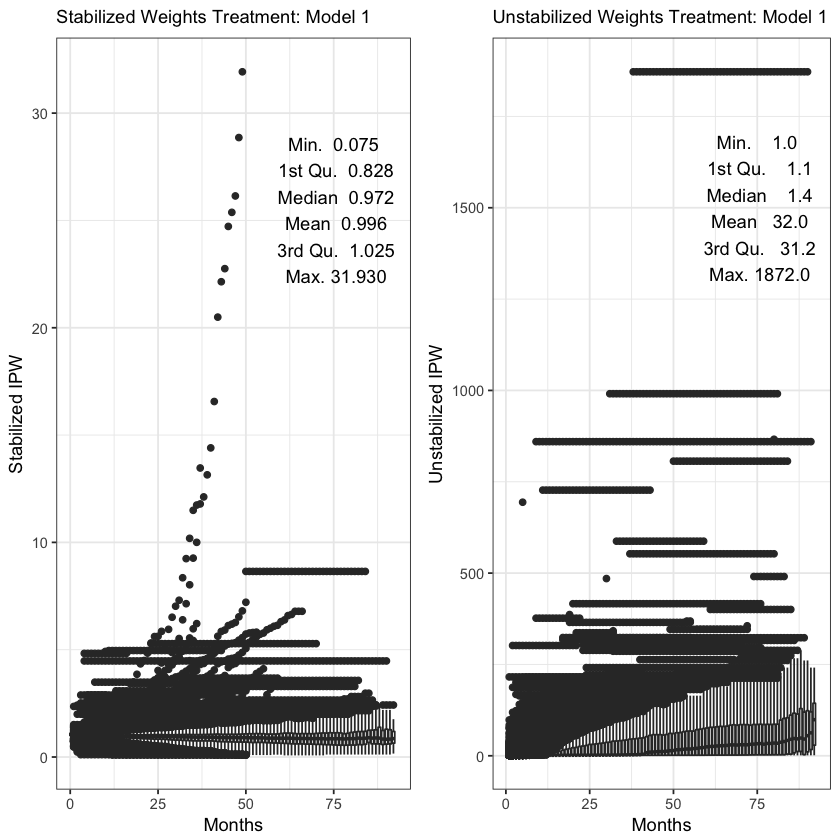

In [61]:
grid.arrange(bxplt.m1.stb, bxplt.m1.unstb,
             ncol=2)

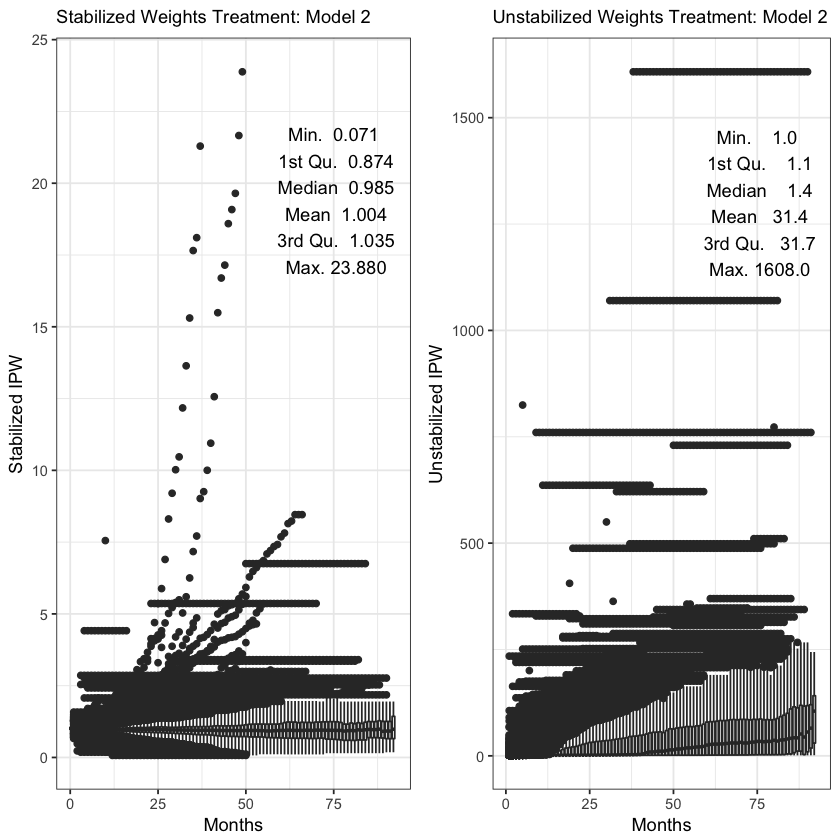

In [73]:
grid.arrange(bxplt.m2.stb, bxplt.m2.unstb,
             ncol=2)

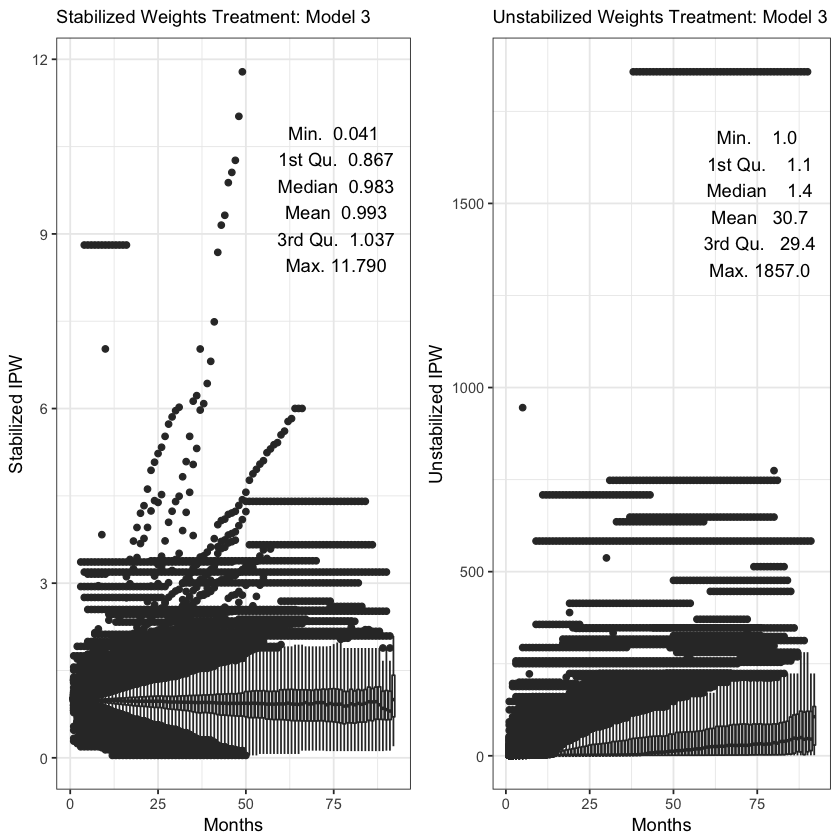

In [80]:
grid.arrange(bxplt.m3.stb, bxplt.m3.unstb,
             ncol=2)

## Comparison of the treatment weights by HAART group

### Histogram: Stabilized weights by HAART initiation

In [101]:
#setup labels to use facet_wrap()
labelsCS = paste("HAART Initiation:", c("Yes", "No"))

In [95]:
#Model 1
#######################################################################################
#create a summary of the ipw weights
summary_mod1_ipwstb_t1 = summary(dfs$m1.ipwstb[dfs$haart==1])
summary_mod1_ipwstb_t0 = summary(dfs$m1.ipwstb[dfs$haart==0])

#paste the names in the summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod1_ipwstb_t1 = paste(names(summary_mod1_ipwstb_t1), 
                            format(summary_mod1_ipwstb_t1, digits=2), 
                            collapse="\n ")
collapse_mod1_ipwstb_t0 = paste(names(summary_mod1_ipwstb_t0), 
                            format(summary_mod1_ipwstb_t0, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod1_ipwstb_t1 = data.frame(x=0.6, y=75, lab = collapse_mod1_ipwstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_mod1_ipwstb_t0 = data.frame(x=0.6, y=75, lab = collapse_mod1_ipwstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

#bind previous min/max annotations for each model
annotate_mod1_ipwstb_total = rbind(annotate_mod1_ipwstb_t1, annotate_mod1_ipwstb_t0)


#Model 2
#######################################################################################

summary_mod2_ipwstb_t1 = summary(dfs$m2.ipwstb[dfs$haart==1])
summary_mod2_ipwstb_t0 = summary(dfs$m2.ipwstb[dfs$haart==0])

collapse_mod2_ipwstb_t1 = paste(names(summary_mod2_ipwstb_t1), 
                            format(summary_mod2_ipwstb_t1, digits=2), 
                            collapse="\n ")
collapse_mod2_ipwstb_t0 = paste(names(summary_mod2_ipwstb_t0), 
                            format(summary_mod2_ipwstb_t0, digits=2), 
                            collapse="\n ")

annotate_mod2_ipwstb_t1 = data.frame(x=0.6, y=75, lab = collapse_mod2_ipwstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_mod2_ipwstb_t0 = data.frame(x=0.6, y=75, lab = collapse_mod2_ipwstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_mod2_ipwstb_total = rbind(annotate_mod2_ipwstb_t1, annotate_mod2_ipwstb_t0)


#Model 3
#######################################################################################

summary_mod3_ipwstb_t1 = summary(dfs$m3.ipwstb[dfs$haart==1])
summary_mod3_ipwstb_t0 = summary(dfs$m3.ipwstb[dfs$haart==0])

collapse_mod3_ipwstb_t1 = paste(names(summary_mod3_ipwstb_t1), 
                            format(summary_mod3_ipwstb_t1, digits=2), 
                            collapse="\n ")
collapse_mod3_ipwstb_t0 = paste(names(summary_mod3_ipwstb_t0), 
                            format(summary_mod3_ipwstb_t0, digits=2), 
                            collapse="\n ")

annotate_mod3_ipwstb_t1 = data.frame(x=0.6, y=75, lab = collapse_mod3_ipwstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_mod3_ipwstb_t0 = data.frame(x=0.6, y=75, lab = collapse_mod3_ipwstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_mod3_ipwstb_total = rbind(annotate_mod3_ipwstb_t1, annotate_mod3_ipwstb_t0)





#check to make sure this is correct
annotate_mod1_ipwstb_total
annotate_mod2_ipwstb_total
annotate_mod3_ipwstb_total

x,y,lab,haart
0.6,75,Min. 0.075 1st Qu. 0.518 Median 0.794 Mean 0.972 3rd Qu. 1.183 Max. 8.648,HAART Initiation: Yes
0.6,75,Min. 0.16 1st Qu. 0.93 Median 0.98 Mean 1.01 3rd Qu. 1.01 Max. 31.93,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 0.071 1st Qu. 0.607 Median 0.951 Mean 1.009 3rd Qu. 1.310 Max. 6.751,HAART Initiation: Yes
0.6,75,Min. 0.18 1st Qu. 0.93 Median 0.99 Mean 1.00 3rd Qu. 1.01 Max. 23.88,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 0.041 1st Qu. 0.552 Median 0.957 Mean 0.995 3rd Qu. 1.351 Max. 8.809,HAART Initiation: Yes
0.6,75,Min. 0.20 1st Qu. 0.93 Median 0.98 Mean 0.99 3rd Qu. 1.01 Max. 11.79,HAART Initiation: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


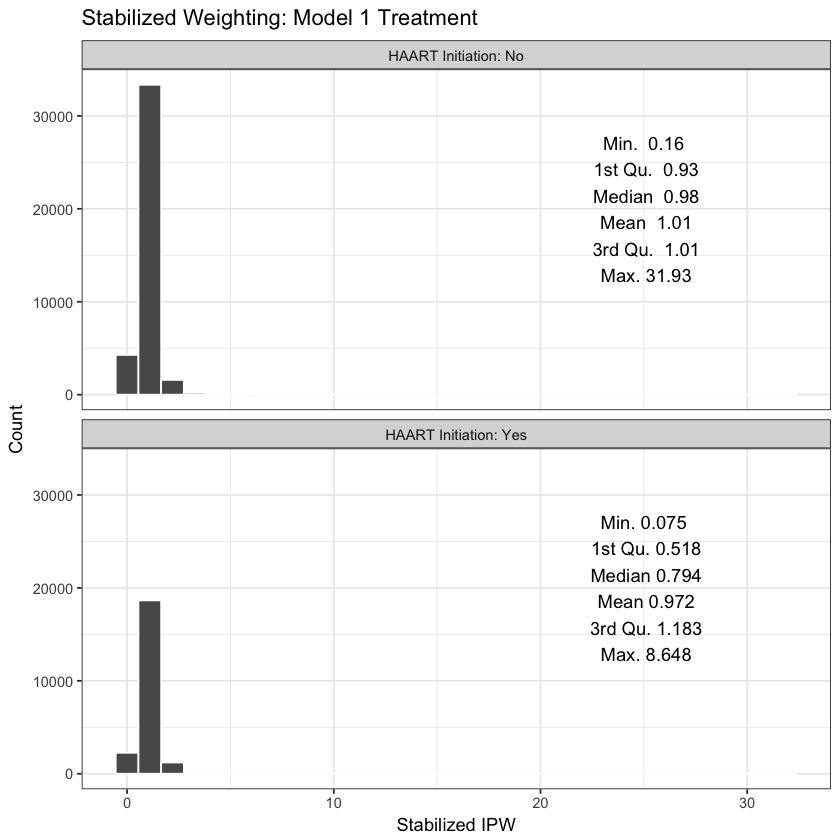

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


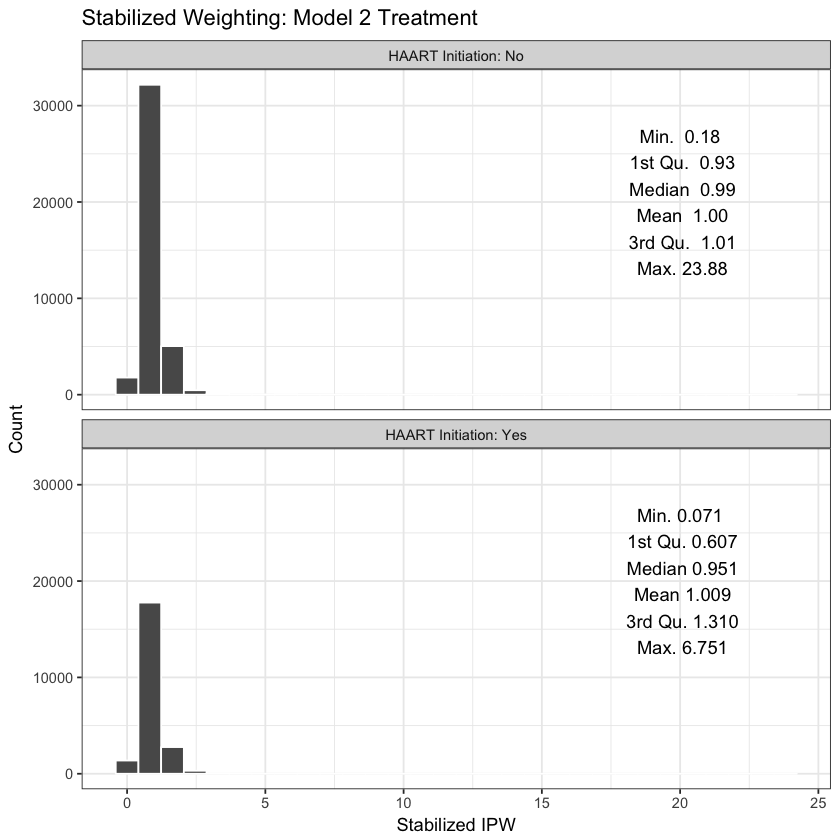

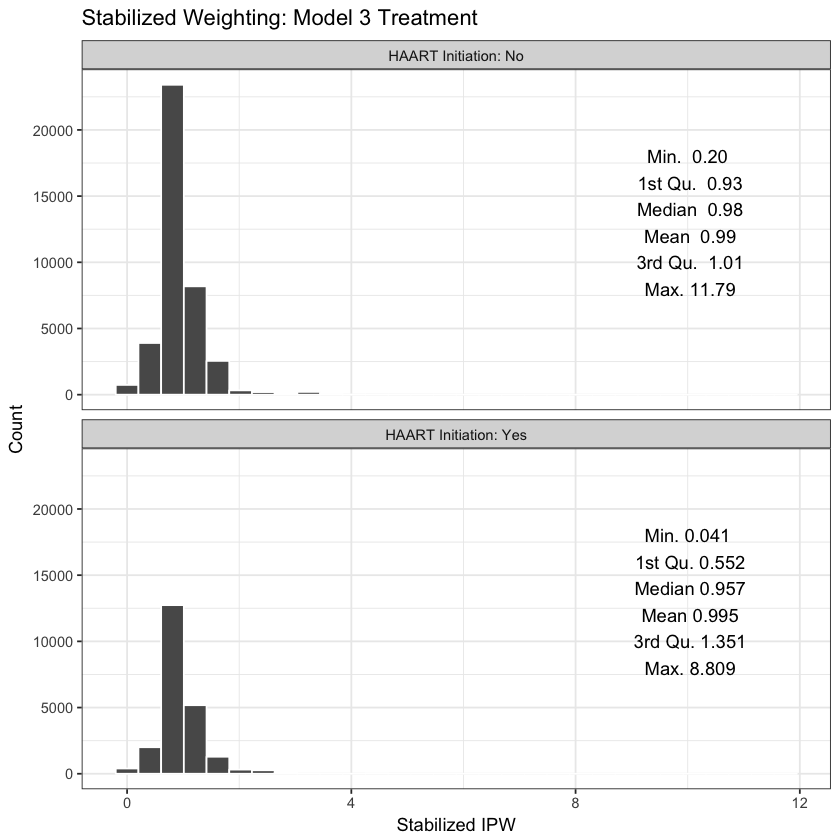

In [102]:
#Model1
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$m1.ipwstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Stabilized IPW") + 
  ylab("Count") + 
  ggtitle("Stabilized Weighting: Model 1 Treatment") + 
  theme_bw() +
  geom_text(data = annotate_mod1_ipwstb_total, 
              aes(x=25, y=20000, label=lab, group=NULL))

#Model2
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$m2.ipwstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Stabilized IPW") + 
  ylab("Count") + 
  ggtitle("Stabilized Weighting: Model 2 Treatment") + 
  theme_bw() +
  geom_text(data = annotate_mod2_ipwstb_total, 
              aes(x=20, y=20000, label=lab, group=NULL))

#Model3
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$m3.ipwstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Stabilized IPW") + 
  ylab("Count") + 
  ggtitle("Stabilized Weighting: Model 3 Treatment") + 
  theme_bw() +
  geom_text(data = annotate_mod3_ipwstb_total, 
              aes(x=10, y=13000, label=lab, group=NULL))

### Histogram: Unstabilized weights by HAART initiation

In [105]:
#Model 1
#######################################################################################
#create a summary of the ipw weights
summary_mod1_ipwunstb_t1 = summary(dfs$m1.ipwunstb[dfs$haart==1])
summary_mod1_ipwunstb_t0 = summary(dfs$m1.ipwunstb[dfs$haart==0])

#paste the names in the summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_mod1_ipwunstb_t1 = paste(names(summary_mod1_ipwunstb_t1), 
                            format(summary_mod1_ipwunstb_t1, digits=2), 
                            collapse="\n ")
collapse_mod1_ipwunstb_t0 = paste(names(summary_mod1_ipwunstb_t0), 
                            format(summary_mod1_ipwunstb_t0, digits=2), 
                            collapse="\n ")

#set into a df
annotate_mod1_ipwunstb_t1 = data.frame(x=0.6, y=75, lab = collapse_mod1_ipwunstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_mod1_ipwunstb_t0 = data.frame(x=0.6, y=75, lab = collapse_mod1_ipwunstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

#bind previous min/max annotations for each model
annotate_mod1_ipwunstb_total = rbind(annotate_mod1_ipwunstb_t1, annotate_mod1_ipwunstb_t0)


#Model 2
#######################################################################################

summary_mod2_ipwunstb_t1 = summary(dfs$m2.ipwunstb[dfs$haart==1])
summary_mod2_ipwunstb_t0 = summary(dfs$m2.ipwunstb[dfs$haart==0])

collapse_mod2_ipwunstb_t1 = paste(names(summary_mod2_ipwunstb_t1), 
                            format(summary_mod2_ipwunstb_t1, digits=2), 
                            collapse="\n ")
collapse_mod2_ipwunstb_t0 = paste(names(summary_mod2_ipwunstb_t0), 
                            format(summary_mod2_ipwunstb_t0, digits=2), 
                            collapse="\n ")

annotate_mod2_ipwunstb_t1 = data.frame(x=0.6, y=75, lab = collapse_mod2_ipwunstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_mod2_ipwunstb_t0 = data.frame(x=0.6, y=75, lab = collapse_mod2_ipwunstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_mod2_ipwunstb_total = rbind(annotate_mod2_ipwunstb_t1, annotate_mod2_ipwunstb_t0)


#Model 3
#######################################################################################

summary_mod3_ipwunstb_t1 = summary(dfs$m3.ipwunstb[dfs$haart==1])
summary_mod3_ipwunstb_t0 = summary(dfs$m3.ipwunstb[dfs$haart==0])

collapse_mod3_ipwunstb_t1 = paste(names(summary_mod3_ipwunstb_t1), 
                            format(summary_mod3_ipwunstb_t1, digits=2), 
                            collapse="\n ")
collapse_mod3_ipwunstb_t0 = paste(names(summary_mod3_ipwunstb_t0), 
                            format(summary_mod3_ipwunstb_t0, digits=2), 
                            collapse="\n ")

annotate_mod3_ipwunstb_t1 = data.frame(x=0.6, y=75, lab = collapse_mod3_ipwunstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_mod3_ipwunstb_t0 = data.frame(x=0.6, y=75, lab = collapse_mod3_ipwunstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_mod3_ipwunstb_total = rbind(annotate_mod3_ipwunstb_t1, annotate_mod3_ipwunstb_t0)





#check to make sure this is correct
annotate_mod1_ipwunstb_total
annotate_mod2_ipwunstb_total
annotate_mod3_ipwunstb_total

x,y,lab,haart
0.6,75,Min. 8 1st Qu. 27 Median 49 Mean 86 3rd Qu. 103 Max. 1872,HAART Initiation: Yes
0.6,75,Min. 1.0 1st Qu. 1.1 Median 1.2 Mean 1.4 3rd Qu. 1.4 Max. 136.1,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 7.3 1st Qu. 27.6 Median 48.9 Mean 84.7 3rd Qu. 99.9 Max. 1608.0,HAART Initiation: Yes
0.6,75,Min. 1.0 1st Qu. 1.1 Median 1.2 Mean 1.4 3rd Qu. 1.4 Max. 119.9,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 3.3 1st Qu. 25.1 Median 49.6 Mean 82.7 3rd Qu. 98.6 Max. 1857.0,HAART Initiation: Yes
0.6,75,Min. 1.0 1st Qu. 1.1 Median 1.2 Mean 1.4 3rd Qu. 1.4 Max. 59.2,HAART Initiation: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


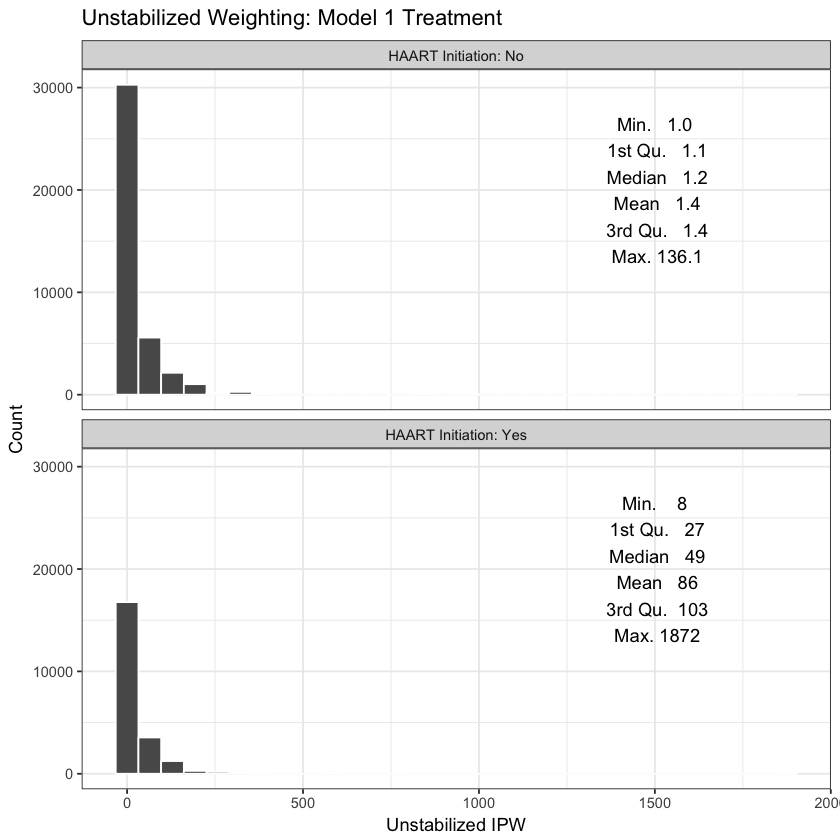

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


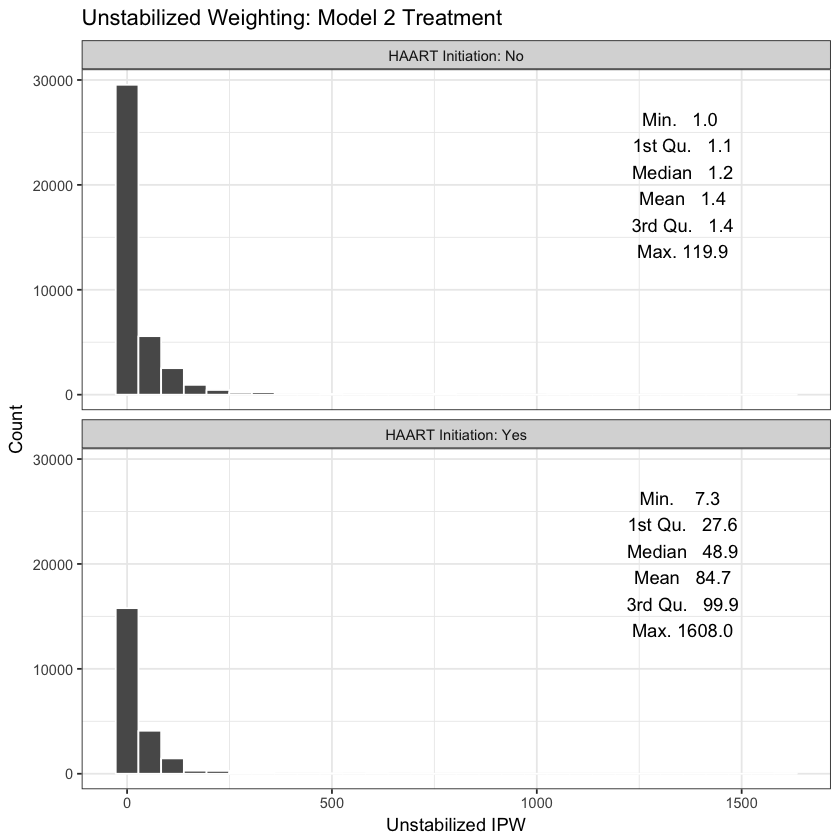

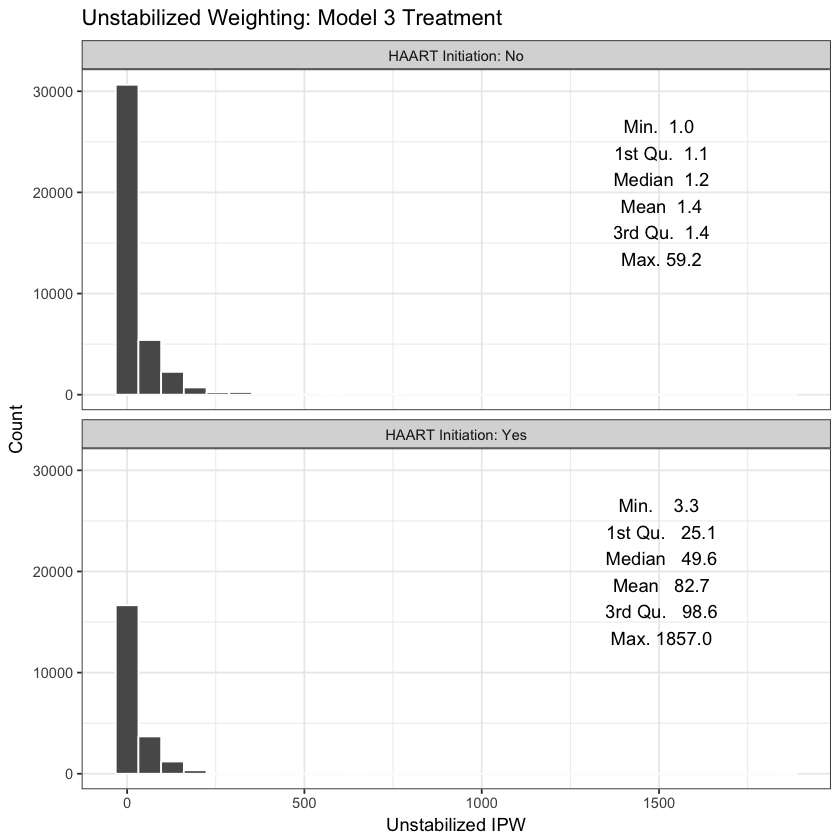

In [109]:
#Model1
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$m1.ipwunstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Unstabilized IPW") + 
  ylab("Count") + 
  ggtitle("Unstabilized Weighting: Model 1 Treatment") + 
  theme_bw() +
  geom_text(data = annotate_mod1_ipwunstb_total, 
              aes(x=1500, y=20000, label=lab, group=NULL))

#Model2
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$m2.ipwunstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Unstabilized IPW") + 
  ylab("Count") + 
  ggtitle("Unstabilized Weighting: Model 2 Treatment") + 
  theme_bw() +
  geom_text(data = annotate_mod2_ipwunstb_total, 
              aes(x=1350, y=20000, label=lab, group=NULL))

#Model3
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$m3.ipwunstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Unstabilized IPW") + 
  ylab("Count") + 
  ggtitle("Unstabilized Weighting: Model 3 Treatment") + 
  theme_bw() +
  geom_text(data = annotate_mod3_ipwunstb_total, 
              aes(x=1500, y=20000, label=lab, group=NULL))

# IPTW for censoring

### Stabilized IPTW

In [82]:
#Model 1
cmod1 = ipwtm(
  exposure = cens,
  family = "survival",
  numerator = ~ haart + BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 +  #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, baseline stage b, risk group
  denominator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar year
    month + timespl1 + timespl2 + timespl3 + Cd42 + Cd43 + Cd44 + #month, splines, cd4
    Cd45 + Cd46 + Cd47 + Rna1 + Rna2 + Rna3 + Rna4 + bevent + #cd4, viral load, stage b event
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + #baseline cd4, viral load
    BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, risk group, stage b event
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

#Model 2
cmod2 = ipwtm(
  exposure = cens,
  family = "survival",
  numerator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline CD4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, stage b event
  denominator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup, #viral load, stage b event, risk group
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

cmod3 = ipwtm(
  exposure = cens,
  family = "survival",
  numerator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline CD4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, stage b event
  denominator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup + #viral load, stage b event, risk group
    LCd42 + LCd43 + LCd44 + LCd45 + LCd46 + LCd47 + #lagged cd4
    LRna1 + LRna2 + LRna3 + LRna4 + #lagged rna/viral load
    inter_Rna2 + inter_Rna3 + inter_Rna4, #interaction of lags
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

print("--Model 1--")
summary(cmod1$ipw.weights) #weights
print("--Model 2--")
summary(cmod2$ipw.weights)
print("--Model 3--")
summary(cmod3$ipw.weights)

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(formula = eval(parse(text = paste("Surv

[1] "--Model 1--"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03082 0.66530 0.81590 0.81760 0.94360 6.63200 

[1] "--Model 2--"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4951  0.9825  0.9987  0.9987  1.0100  2.9130 

[1] "--Model 3--"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4020  0.9710  1.0000  0.9994  1.0200  4.2610 

### Unstabilized IPTW

In [83]:
#Model 1
cmod1.unstb = ipwtm(
  exposure = cens,
  family = "survival",
  denominator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calendar year
    month + timespl1 + timespl2 + timespl3 + Cd42 + Cd43 + Cd44 + #month, splines, cd4
    Cd45 + Cd46 + Cd47 + Rna1 + Rna2 + Rna3 + Rna4 + bevent + #cd4, viral load, stage b event
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + #baseline cd4, viral load
    BRna3 + BRna4 + Bbevent + riskgroup, #baseline viral load, risk group, stage b event
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

#Model 2
cmod2.unstb = ipwtm(
  exposure = cens,
  family = "survival",
  denominator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup, #viral load, stage b event, risk group
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

cmod3.unstb = ipwtm(
  exposure = cens,
  family = "survival",
  denominator = ~ haart + Year2 + Year3 + Year4 + Year5 + Year7 + Year8 + #calender years
    month + timespl1 + timespl2 + timespl3 + #month, splines
    Agegrp15 + Agegrp30 + Agegrp40 + #age groups
    BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + #baseline cd4
    BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + #baseline viral load, stage b event
    Cd42 + Cd43 + Cd44 + Cd45 + Cd46 + Cd47 + #current cd4
    Rna1 + Rna2 + Rna3 + Rna4 + bevent + riskgroup + #viral load, stage b event, risk group
    LCd42 + LCd43 + LCd44 + LCd45 + LCd46 + LCd47 + #lagged cd4
    LRna1 + LRna2 + LRna3 + LRna4 + #lagged rna/viral load
    inter_Rna2 + inter_Rna3 + inter_Rna4, #interaction of lags
  id = id,
  tstart = mstart, #tstart, with -1 first
  timevar = month, #fuptime with 0 first
  type = "first", #first time we start HAART we stay there
  data=dfs
)

print("--Model 1--")
summary(cmod1.unstb$ipw.weights) #weights
print("--Model 2--")
summary(cmod2.unstb$ipw.weights)
print("--Model 3--")
summary(cmod3.unstb$ipw.weights)

Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(formula = eval(parse(text = paste("Surv(", deparse(tempcall$tstart), :
“X matrix deemed to be singular; variable 8 9 10 11”

[1] "--Model 1--"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.198   1.409   3.083   1.731 497.100 

[1] "--Model 2--"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.197   1.407   3.081   1.732 502.900 

[1] "--Model 3--"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.193   1.404   3.066   1.736 554.300 

In [84]:
#assign these into the dataframe 
dfs$cm1.ipwstb = cmod1$ipw.weights
dfs$cm1.ipwunstb = cmod1.unstb$ipw.weights
dfs$cm2.ipwstb = cmod2$ipw.weights
dfs$cm2.ipwunstb = cmod2.unstb$ipw.weights
dfs$cm3.ipwstb = cmod3$ipw.weights
dfs$cm3.ipwunstb = cmod3.unstb$ipw.weights

## Plot the stabilized/unstabilized weights for censoring

### Boxplot of stabilized weights

In [85]:
#Model 1
summary_cmod1_ipwstb_t = summary(cmod1$ipw.weights)
collapse_cmod1_ipwstb_t = paste(names(summary_cmod1_ipwstb_t), 
                            format(summary_cmod1_ipwstb_t, digits=2), 
                            collapse="\n ")
annotate_cmod1_ipwstb_t = data.frame(x=0.6, y=75, 
                                     lab = collapse_cmod1_ipwstb_t)


#Model 2
summary_cmod2_ipwstb_t = summary(cmod2$ipw.weights)
collapse_cmod2_ipwstb_t = paste(names(summary_cmod2_ipwstb_t), 
                            format(summary_cmod2_ipwstb_t, digits=2), 
                            collapse="\n ")
annotate_cmod2_ipwstb_t = data.frame(x=0.6, y=75, 
                                     lab = collapse_cmod2_ipwstb_t)


#Model 3
summary_cmod3_ipwstb_t = summary(cmod3$ipw.weights)
collapse_cmod3_ipwstb_t = paste(names(summary_cmod3_ipwstb_t), 
                            format(summary_cmod3_ipwstb_t, digits=2), 
                            collapse="\n ")
annotate_cmod3_ipwstb_t = data.frame(x=0.6, y=75, 
                                     lab = collapse_cmod3_ipwstb_t)


In [98]:
#Model 1
bxplt.cm1.stb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$cm1.ipwstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Stabilized Weights Censoring: Model 1") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_cmod1_ipwstb_t, 
              aes(x=31.25, y=6, label=lab, group=NULL))

#Model 2
bxplt.cm2.stb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$cm2.ipwstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Stabilized Weights Censoring: Model 2") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_cmod2_ipwstb_t, 
              aes(x=25, y=2.65, label=lab, group=NULL))

#Model 3
bxplt.cm3.stb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$cm3.ipwstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Stabilized Weights Censoring: Model 3") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_cmod3_ipwstb_t, 
              aes(x=25, y=3.85, label=lab, group=NULL))


### Boxplot of unstabilized weights

In [87]:
#Model 1
summary_cmod1_ipwunstb_t = summary(cmod1$ipw.weights)
collapse_cmod1_ipwunstb_t = paste(names(summary_cmod1_ipwunstb_t), 
                            format(summary_cmod1_ipwunstb_t, digits=2), 
                            collapse="\n ")
annotate_cmod1_ipwunstb_t = data.frame(x=0.6, y=75, 
                                     lab = collapse_cmod1_ipwunstb_t)


#Model 2
summary_cmod2_ipwunstb_t = summary(cmod2$ipw.weights)
collapse_cmod2_ipwunstb_t = paste(names(summary_cmod2_ipwunstb_t), 
                            format(summary_cmod2_ipwunstb_t, digits=2), 
                            collapse="\n ")
annotate_cmod2_ipwunstb_t = data.frame(x=0.6, y=75, 
                                     lab = collapse_cmod2_ipwunstb_t)


#Model 3
summary_cmod3_ipwunstb_t = summary(cmod3$ipw.weights)
collapse_cmod3_ipwunstb_t = paste(names(summary_cmod3_ipwunstb_t), 
                            format(summary_cmod3_ipwunstb_t, digits=2), 
                            collapse="\n ")
annotate_cmod3_ipwunstb_t = data.frame(x=0.6, y=75, 
                                     lab = collapse_cmod3_ipwunstb_t)


In [96]:
#Model 1
bxplt.cm1.unstb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$cm1.ipwunstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Unstabilized Weights Censoring: Model 1") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_cmod1_ipwunstb_t, 
              aes(x=31.25, y=450, label=lab, group=NULL))

#Model 2
bxplt.cm2.unstb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$cm2.ipwunstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Unstabilized Weights Censoring: Model 2") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_cmod2_ipwunstb_t, 
              aes(x=25, y=450, label=lab, group=NULL))

#Model 3
bxplt.cm3.unstb = ggplot(data=dfs, aes(x=dfs$month, y=dfs$cm3.ipwunstb, group=dfs$month)) + 
    geom_boxplot() +
    ggtitle("Unstabilized Weights Censoring: Model 3") +
    labs(x="Months",y="Stabilized IPW") +
    theme_bw() +
    theme(plot.title = element_text(size=11)) +
    geom_text(data = annotate_cmod3_ipwunstb_t, 
              aes(x=25, y=500, label=lab, group=NULL))

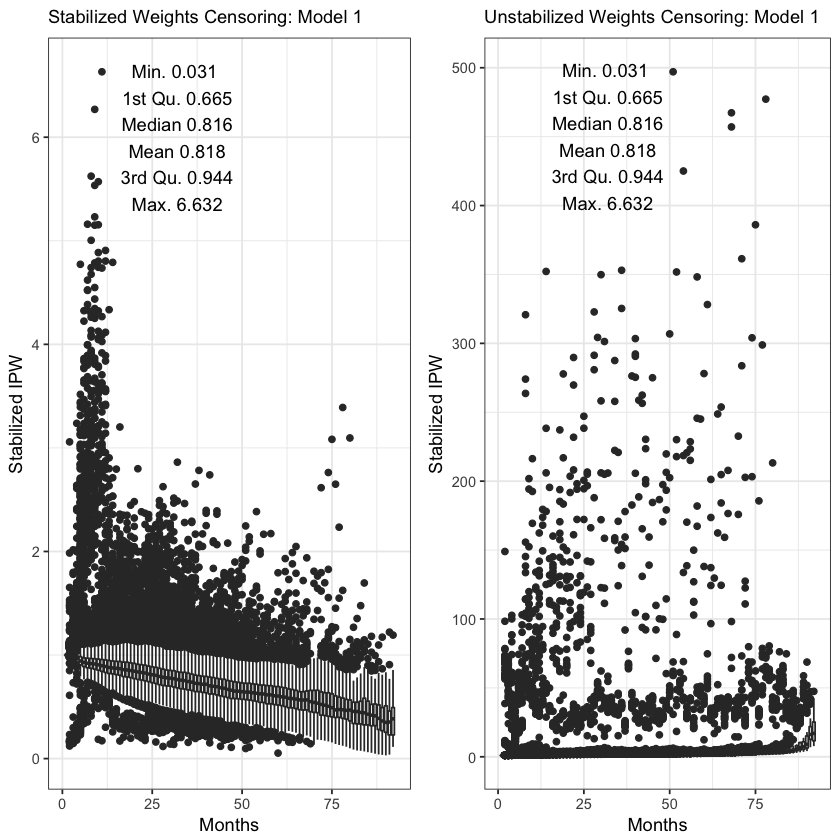

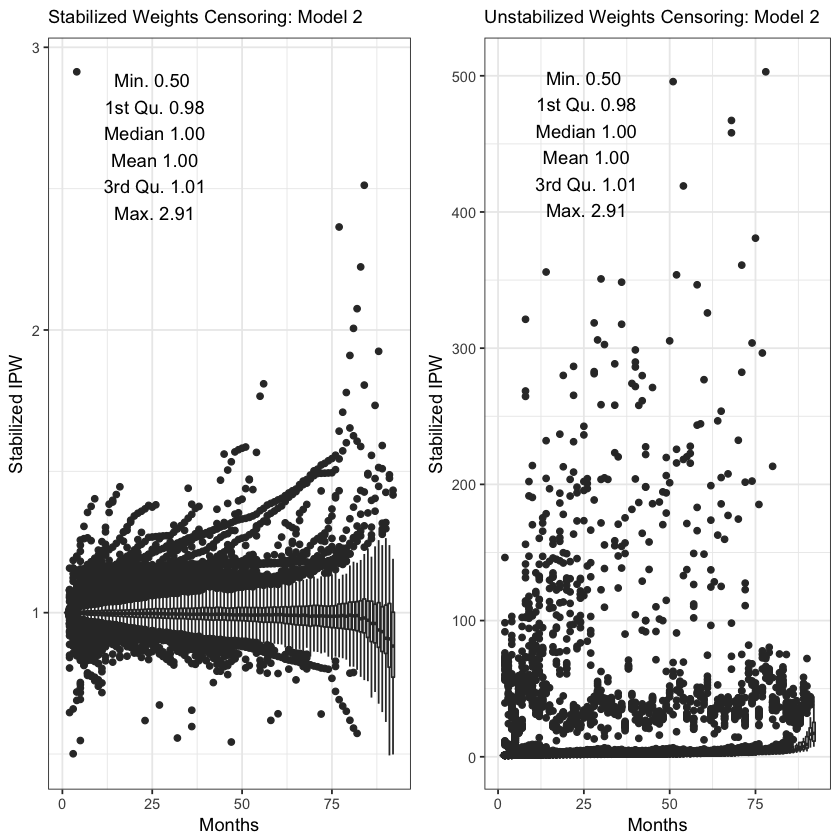

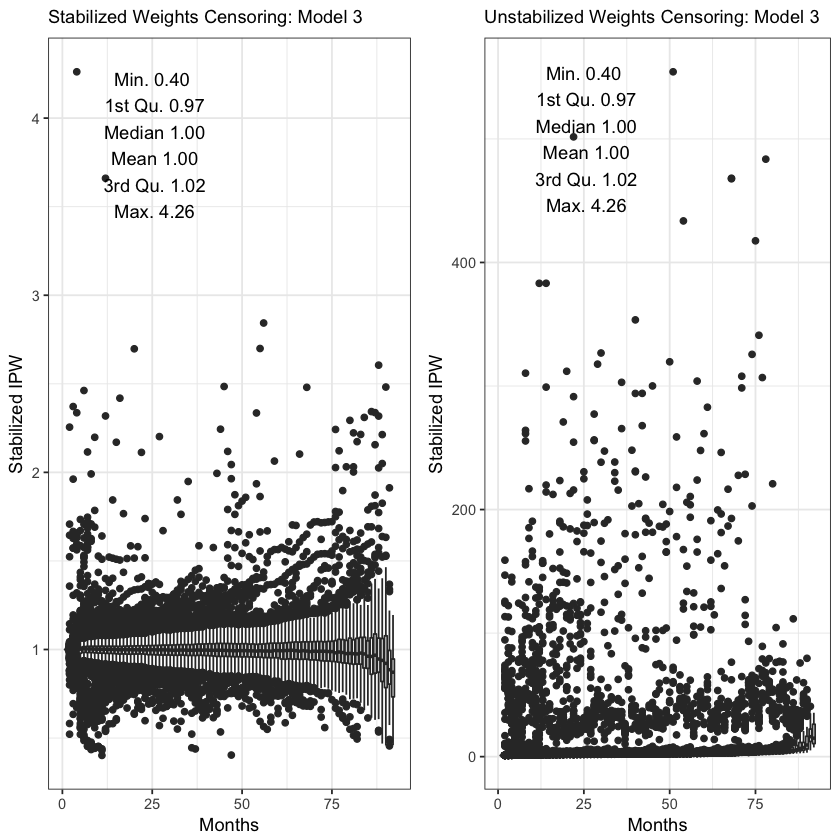

In [99]:
grid.arrange(bxplt.cm1.stb, bxplt.cm1.unstb,
             ncol=2)

grid.arrange(bxplt.cm2.stb, bxplt.cm2.unstb,
             ncol=2)

grid.arrange(bxplt.cm3.stb, bxplt.cm3.unstb,
             ncol=2)

## Comparison of the censoring weights by HAART group

### Histogram: Stabilized weights for being censored

In [103]:
#Model 1
#######################################################################################
#create a summary of the ipw weights
summary_cmod1_ipwstb_t1 = summary(dfs$cm1.ipwstb[dfs$haart==1])
summary_cmod1_ipwstb_t0 = summary(dfs$cm1.ipwstb[dfs$haart==0])

#paste the names in the summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_cmod1_ipwstb_t1 = paste(names(summary_cmod1_ipwstb_t1), 
                            format(summary_cmod1_ipwstb_t1, digits=2), 
                            collapse="\n ")
collapse_cmod1_ipwstb_t0 = paste(names(summary_cmod1_ipwstb_t0), 
                            format(summary_cmod1_ipwstb_t0, digits=2), 
                            collapse="\n ")

#set into a df
annotate_cmod1_ipwstb_t1 = data.frame(x=0.6, y=75, lab = collapse_cmod1_ipwstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_cmod1_ipwstb_t0 = data.frame(x=0.6, y=75, lab = collapse_cmod1_ipwstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

#bind previous min/max annotations for each model
annotate_cmod1_ipwstb_total = rbind(annotate_cmod1_ipwstb_t1, annotate_cmod1_ipwstb_t0)


#Model 2
#######################################################################################

summary_cmod2_ipwstb_t1 = summary(dfs$cm2.ipwstb[dfs$haart==1])
summary_cmod2_ipwstb_t0 = summary(dfs$cm2.ipwstb[dfs$haart==0])

collapse_cmod2_ipwstb_t1 = paste(names(summary_cmod2_ipwstb_t1), 
                            format(summary_cmod2_ipwstb_t1, digits=2), 
                            collapse="\n ")
collapse_cmod2_ipwstb_t0 = paste(names(summary_cmod2_ipwstb_t0), 
                            format(summary_cmod2_ipwstb_t0, digits=2), 
                            collapse="\n ")

annotate_cmod2_ipwstb_t1 = data.frame(x=0.6, y=75, lab = collapse_cmod2_ipwstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_cmod2_ipwstb_t0 = data.frame(x=0.6, y=75, lab = collapse_cmod2_ipwstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_cmod2_ipwstb_total = rbind(annotate_cmod2_ipwstb_t1, annotate_cmod2_ipwstb_t0)


#Model 3
#######################################################################################

summary_cmod3_ipwstb_t1 = summary(dfs$cm3.ipwstb[dfs$haart==1])
summary_cmod3_ipwstb_t0 = summary(dfs$cm3.ipwstb[dfs$haart==0])

collapse_cmod3_ipwstb_t1 = paste(names(summary_cmod3_ipwstb_t1), 
                            format(summary_cmod3_ipwstb_t1, digits=2), 
                            collapse="\n ")
collapse_cmod3_ipwstb_t0 = paste(names(summary_cmod3_ipwstb_t0), 
                            format(summary_cmod3_ipwstb_t0, digits=2), 
                            collapse="\n ")

annotate_cmod3_ipwstb_t1 = data.frame(x=0.6, y=75, lab = collapse_cmod3_ipwstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_cmod3_ipwstb_t0 = data.frame(x=0.6, y=75, lab = collapse_cmod3_ipwstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_cmod3_ipwstb_total = rbind(annotate_cmod3_ipwstb_t1, annotate_cmod3_ipwstb_t0)





#check to make sure this is correct
annotate_cmod1_ipwstb_total
annotate_cmod2_ipwstb_total
annotate_cmod3_ipwstb_total

x,y,lab,haart
0.6,75,Min. 0.097 1st Qu. 0.606 Median 0.742 Mean 0.746 3rd Qu. 0.872 Max. 4.792,HAART Initiation: Yes
0.6,75,Min. 0.031 1st Qu. 0.711 Median 0.856 Mean 0.858 3rd Qu. 0.971 Max. 6.632,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 0.57 1st Qu. 0.98 Median 1.00 Mean 1.00 3rd Qu. 1.02 Max. 2.51,HAART Initiation: Yes
0.6,75,Min. 0.50 1st Qu. 0.99 Median 1.00 Mean 1.00 3rd Qu. 1.01 Max. 2.91,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 0.43 1st Qu. 0.96 Median 0.99 Mean 1.00 3rd Qu. 1.02 Max. 2.84,HAART Initiation: Yes
0.6,75,Min. 0.40 1st Qu. 0.98 Median 1.00 Mean 1.00 3rd Qu. 1.02 Max. 4.26,HAART Initiation: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


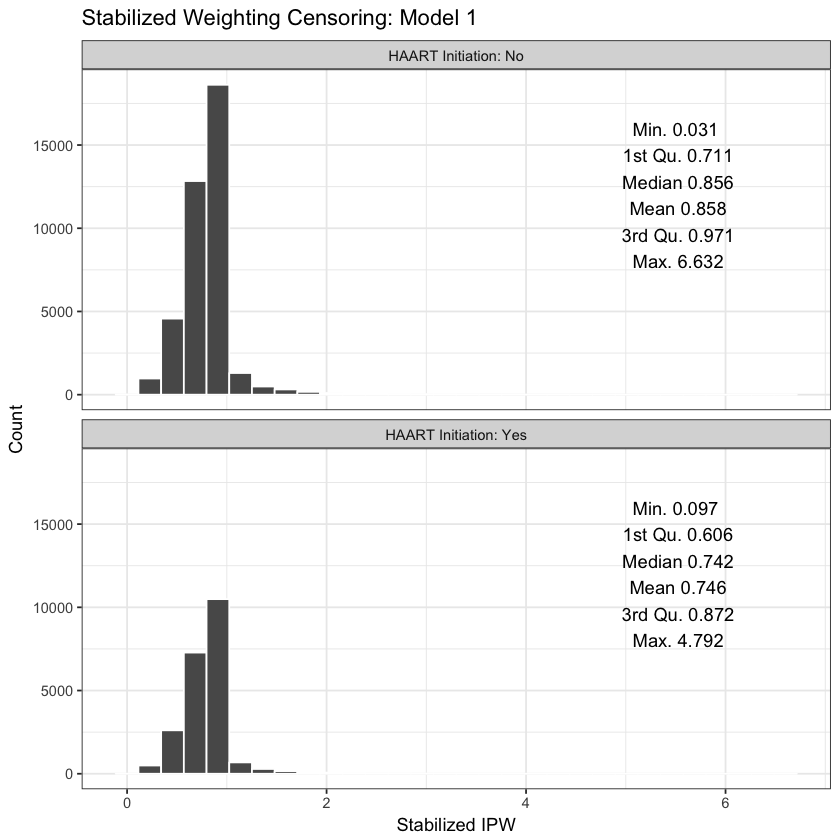

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


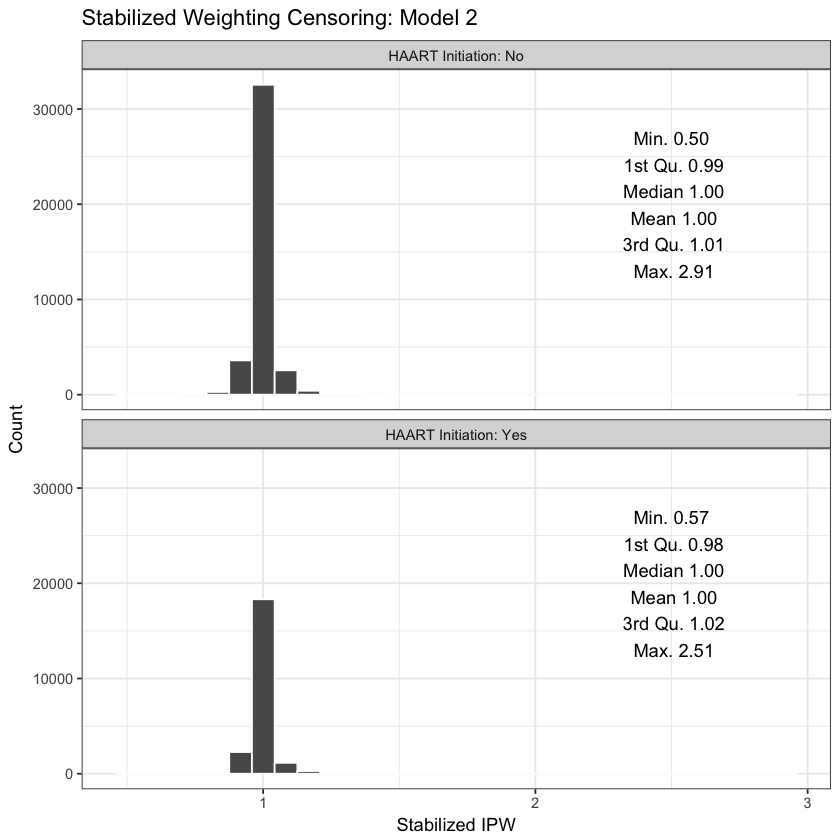

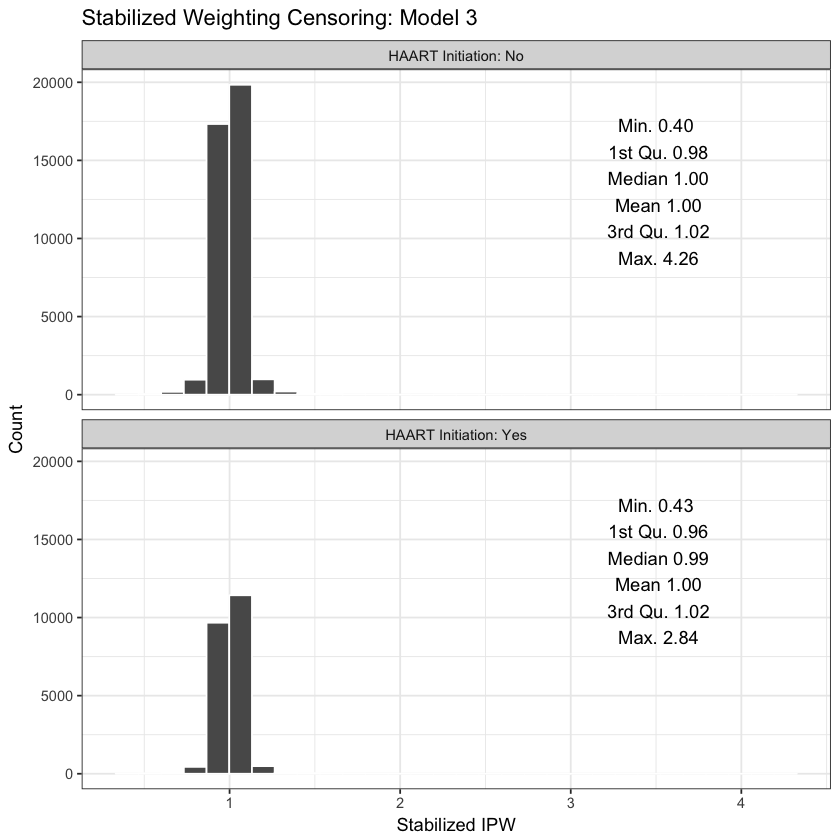

In [104]:
#Model1
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$cm1.ipwstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Stabilized IPW") + 
  ylab("Count") + 
  ggtitle("Stabilized Weighting Censoring: Model 1") + 
  theme_bw() +
  geom_text(data = annotate_cmod1_ipwstb_total, 
              aes(x=5.5, y=12000, label=lab, group=NULL))

#Model2
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$cm2.ipwstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Stabilized IPW") + 
  ylab("Count") + 
  ggtitle("Stabilized Weighting Censoring: Model 2") + 
  theme_bw() +
  geom_text(data = annotate_cmod2_ipwstb_total, 
              aes(x=2.5, y=20000, label=lab, group=NULL))

#Model3
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$cm3.ipwstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Stabilized IPW") + 
  ylab("Count") + 
  ggtitle("Stabilized Weighting Censoring: Model 3") + 
  theme_bw() +
  geom_text(data = annotate_cmod3_ipwstb_total, 
              aes(x=3.5, y=13000, label=lab, group=NULL))

### Histogram: Unstabilized weights for being censored

In [140]:
#Model 1
#######################################################################################
#create a summary of the ipw weights
summary_cmod1_ipwunstb_t1 = summary(dfs$cm1.ipwunstb[dfs$haart==1])
summary_cmod1_ipwunstb_t0 = summary(dfs$cm1.ipwunstb[dfs$haart==0])

#paste the names in the summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
collapse_cmod1_ipwunstb_t1 = paste(names(summary_cmod1_ipwunstb_t1), 
                            format(summary_cmod1_ipwunstb_t1, digits=2), 
                            collapse="\n ")
collapse_cmod1_ipwunstb_t0 = paste(names(summary_cmod1_ipwunstb_t0), 
                            format(summary_cmod1_ipwunstb_t0, digits=2), 
                            collapse="\n ")

#set into a df
annotate_cmod1_ipwunstb_t1 = data.frame(x=0.6, y=75, lab = collapse_cmod1_ipwunstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_cmod1_ipwunstb_t0 = data.frame(x=0.6, y=75, lab = collapse_cmod1_ipwunstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

#bind previous min/max annotations for each model
annotate_cmod1_ipwunstb_total = rbind(annotate_cmod1_ipwunstb_t1, annotate_cmod1_ipwunstb_t0)


#Model 2
#######################################################################################

summary_cmod2_ipwunstb_t1 = summary(dfs$cm2.ipwunstb[dfs$haart==1])
summary_cmod2_ipwunstb_t0 = summary(dfs$cm2.ipwunstb[dfs$haart==0])

collapse_cmod2_ipwunstb_t1 = paste(names(summary_cmod2_ipwunstb_t1), 
                            format(summary_cmod2_ipwunstb_t1, digits=2), 
                            collapse="\n ")
collapse_cmod2_ipwunstb_t0 = paste(names(summary_cmod2_ipwunstb_t0), 
                            format(summary_cmod2_ipwunstb_t0, digits=2), 
                            collapse="\n ")

annotate_cmod2_ipwunstb_t1 = data.frame(x=0.6, y=75, lab = collapse_cmod2_ipwunstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_cmod2_ipwunstb_t0 = data.frame(x=0.6, y=75, lab = collapse_cmod2_ipwunstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_cmod2_ipwunstb_total = rbind(annotate_cmod2_ipwunstb_t1, annotate_cmod2_ipwunstb_t0)


#Model 3
#######################################################################################

summary_cmod3_ipwunstb_t1 = summary(dfs$cm3.ipwunstb[dfs$haart==1])
summary_cmod3_ipwunstb_t0 = summary(dfs$cm3.ipwunstb[dfs$haart==0])

collapse_cmod3_ipwunstb_t1 = paste(names(summary_cmod3_ipwunstb_t1), 
                            format(summary_cmod3_ipwunstb_t1, digits=2), 
                            collapse="\n ")
collapse_cmod3_ipwunstb_t0 = paste(names(summary_cmod3_ipwunstb_t0), 
                            format(summary_cmod3_ipwunstb_t0, digits=2), 
                            collapse="\n ")

annotate_cmod3_ipwunstb_t1 = data.frame(x=0.6, y=75, lab = collapse_cmod3_ipwunstb_t1,
                               haart = factor(labelsCS[1], 
                               levels=c(labelsCS[1], labelsCS[2])))
annotate_cmod3_ipwunstb_t0 = data.frame(x=0.6, y=75, lab = collapse_cmod3_ipwunstb_t0,
                               haart = factor(labelsCS[2], 
                               levels=c(labelsCS[1], labelsCS[2])))

annotate_cmod3_ipwunstb_total = rbind(annotate_cmod3_ipwunstb_t1, annotate_cmod3_ipwunstb_t0)





#check to make sure this is correct
annotate_cmod1_ipwunstb_total
annotate_cmod2_ipwunstb_total
annotate_cmod3_ipwunstb_total

x,y,lab,haart
0.6,75,Min. 1.0 1st Qu. 1.3 Median 1.6 Mean 3.2 3rd Qu. 1.9 Max. 477.2,HAART Initiation: Yes
0.6,75,Min. 1.0 1st Qu. 1.1 Median 1.3 Mean 3.0 3rd Qu. 1.6 Max. 497.1,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 1.0 1st Qu. 1.3 Median 1.6 Mean 3.2 3rd Qu. 1.9 Max. 502.9,HAART Initiation: Yes
0.6,75,Min. 1.0 1st Qu. 1.1 Median 1.3 Mean 3.0 3rd Qu. 1.6 Max. 495.7,HAART Initiation: No


x,y,lab,haart
0.6,75,Min. 1.0 1st Qu. 1.3 Median 1.5 Mean 3.2 3rd Qu. 1.9 Max. 483.6,HAART Initiation: Yes
0.6,75,Min. 1.0 1st Qu. 1.1 Median 1.3 Mean 3.0 3rd Qu. 1.6 Max. 554.3,HAART Initiation: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


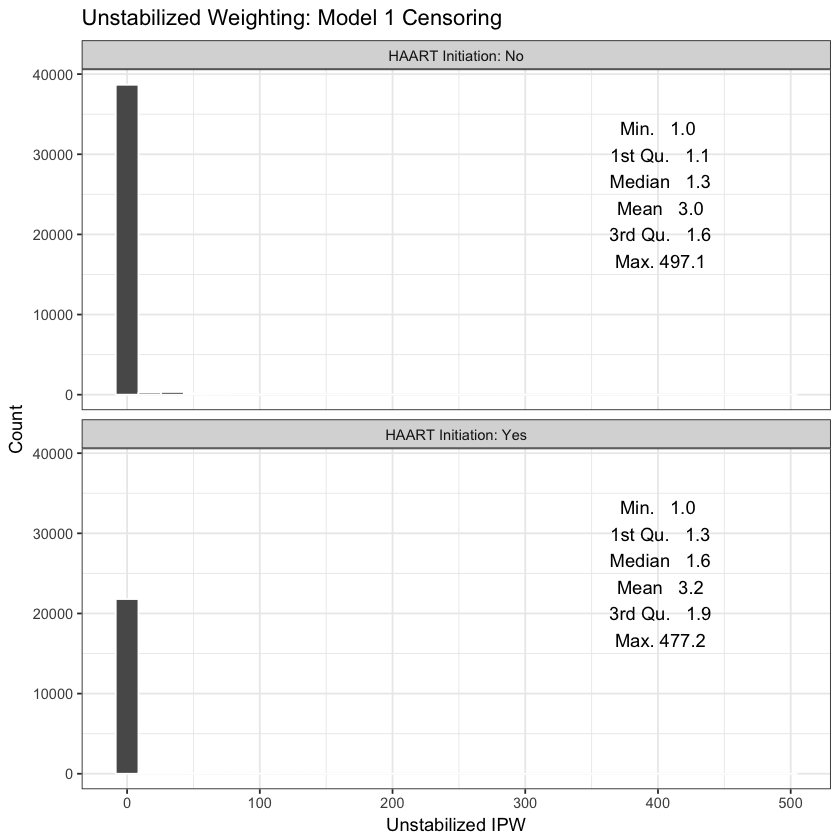

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


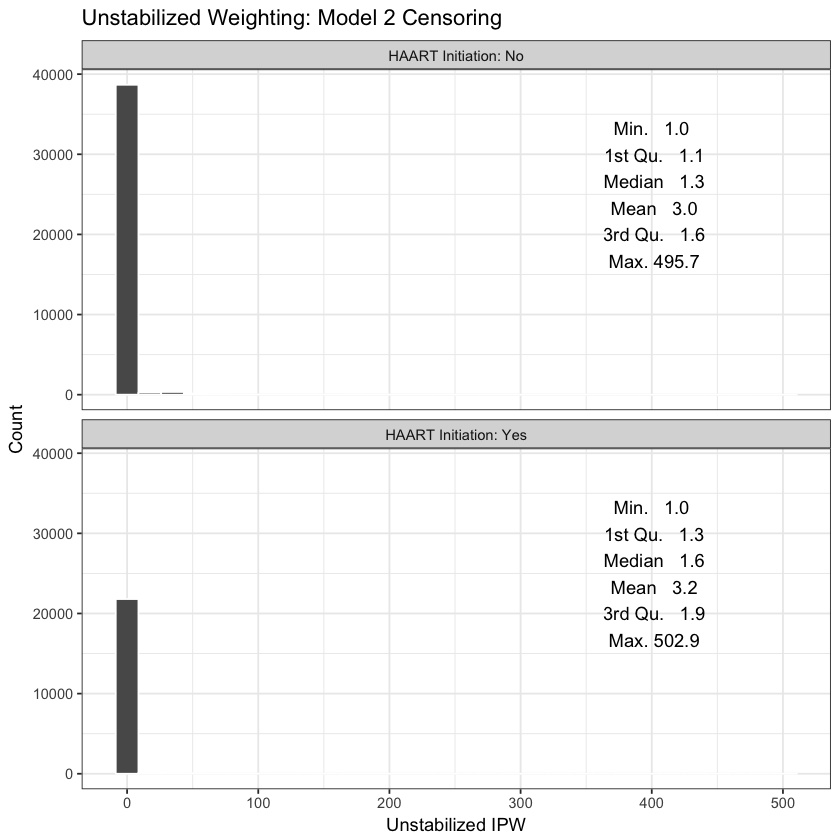

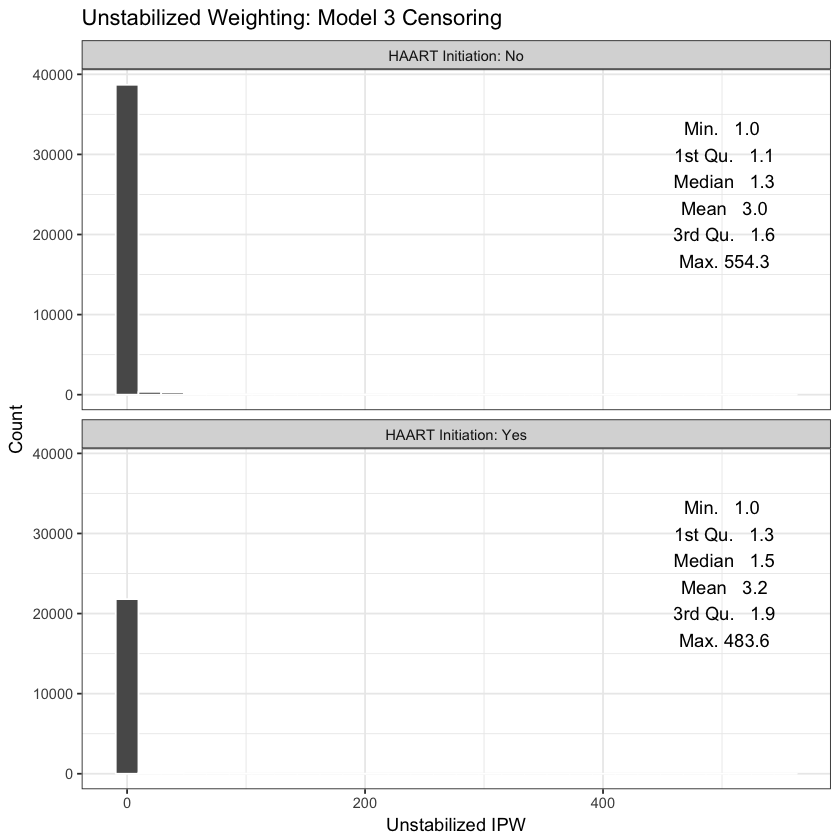

In [145]:
#Model1
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$cm1.ipwunstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Unstabilized IPW") + 
  ylab("Count") + 
  ggtitle("Unstabilized Weighting: Model 1 Censoring") + 
  theme_bw() +
  geom_text(data = annotate_cmod1_ipwunstb_total, 
              aes(x=400, y=25000, label=lab, group=NULL))

#Model2
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$cm2.ipwunstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Unstabilized IPW") + 
  ylab("Count") + 
  ggtitle("Unstabilized Weighting: Model 2 Censoring") + 
  theme_bw() +
  geom_text(data = annotate_cmod2_ipwunstb_total, 
              aes(x=400, y=25000, label=lab, group=NULL))

#Model3
dfs %>%
  mutate(haart = ifelse(haart==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x=dfs$cm3.ipwunstb)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~haart, nrow=2, ncol=1) + 
  xlab("Unstabilized IPW") + 
  ylab("Count") + 
  ggtitle("Unstabilized Weighting: Model 3 Censoring") + 
  theme_bw() +
  geom_text(data = annotate_cmod3_ipwunstb_total, 
              aes(x=500, y=25000, label=lab, group=NULL))

# Cox Proportional Hazards Regression  
## Survival Models

### Cox model with no weighting

In [134]:
coxph.nowt = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart + 
                    cluster(id), data=dfs))

coxph.nowt

Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + cluster(id), 
    data = dfs)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

         coef exp(coef) se(coef) robust se      z Pr(>|z|)
haart -0.2944    0.7450   0.1950    0.1967 -1.497    0.134

      exp(coef) exp(-coef) lower .95 upper .95
haart     0.745      1.342    0.5067     1.095

Concordance= 0.523  (se = 0.016 )
Rsquare= 0   (max possible= 0.035 )
Likelihood ratio test= 2.35  on 1 df,   p=0.1253
Wald test            = 2.24  on 1 df,   p=0.1344
Score (logrank) test = 2.29  on 1 df,   p=0.1302,   Robust = 2.4  p=0.121

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).

### Cox model with stabilized weighting

In [148]:
#Model 1
coxph.m1.stb = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart + 
                       BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 +  
                       BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + 
                       riskgroup + cluster(id), 
                    data=dfs, 
                    weights = mod1$ipw.weights*cmod1$ipw.weights))

#Model 2
coxph.m2.stb = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart +
                       Year2 + Year3 + Year4 + Year5 + Year7 + Year8 +
                       month + timespl1 + timespl2 + timespl3 +
                       Agegrp15 + Agegrp30 + Agegrp40 + 
                       BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + 
                       BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + 
                       riskgroup + cluster(id), 
                    data=dfs, 
                    weights = mod2$ipw.weights*cmod2$ipw.weights))

#Model 3
coxph.m3.stb = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart +
                       Year2 + Year3 + Year4 + Year5 + Year7 + Year8 +
                       month + timespl1 + timespl2 + timespl3 +
                       Agegrp15 + Agegrp30 + Agegrp40 + 
                       BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + 
                       BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + 
                       riskgroup + cluster(id), 
                    data=dfs, 
                    weights = mod3$ipw.weights*cmod3$ipw.weights))

print("--Model 1--")
coxph.m1.stb
print("--Model 2--")
coxph.m2.stb
print("--Model 3--")
coxph.m3.stb

Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“X matrix deemed to be singular; variable 8 9 10 11”

[1] "--Model 1--"


Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + BCd42 + 
    BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + BRna3 + 
    BRna4 + Bbevent + riskgroup + cluster(id), data = dfs, weights = mod1$ipw.weights * 
    cmod1$ipw.weights)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

              coef exp(coef) se(coef) robust se      z Pr(>|z|)    
haart     -1.53662   0.21511  0.23697   0.32680 -4.702 2.58e-06 ***
BCd42     -0.85197   0.42657  0.50683   0.55220 -1.543 0.122864    
BCd43     -0.45919   0.63180  0.42810   0.44137 -1.040 0.298167    
BCd44     -1.18019   0.30722  0.42426   0.42081 -2.805 0.005038 ** 
BCd45     -1.56295   0.20952  0.43244   0.44115 -3.543 0.000396 ***
BCd46     -1.52680   0.21723  0.43478   0.45192 -3.378 0.000729 ***
BCd47     -2.46922   0.08465  0.55119   0.52881 -4.669 3.02e-06 ***
BRna1     -2.53152   0.07954  0.71647   0.66250 -3.821 0.000133 ***
BRna2     -1.61133   0.19962  0.54662   0.5290

[1] "--Model 2--"


Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + Year2 + 
    Year3 + Year4 + Year5 + Year7 + Year8 + month + timespl1 + 
    timespl2 + timespl3 + Agegrp15 + Agegrp30 + Agegrp40 + BCd42 + 
    BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + BRna3 + 
    BRna4 + Bbevent + riskgroup + cluster(id), data = dfs, weights = mod2$ipw.weights * 
    cmod2$ipw.weights)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

              coef exp(coef) se(coef) robust se      z Pr(>|z|)    
haart     -1.50612   0.22177  0.20531   0.30362 -4.961 7.03e-07 ***
Year2      0.34241   1.40833  0.25018   0.35748  0.958 0.338153    
Year3      0.12055   1.12812  0.25492   0.33769  0.357 0.721096    
Year4     -0.10875   0.89696  0.26120   0.28812 -0.377 0.705851    
Year5     -0.56314   0.56942  0.27272   0.30482 -1.847 0.064686 .  
Year7     -0.83605   0.43342  0.29432   0.38821 -2.154 0.031271 *  
Year8     -0.97841   0.37591  0.37259   0.46423 -2

[1] "--Model 3--"


Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + Year2 + 
    Year3 + Year4 + Year5 + Year7 + Year8 + month + timespl1 + 
    timespl2 + timespl3 + Agegrp15 + Agegrp30 + Agegrp40 + BCd42 + 
    BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + BRna3 + 
    BRna4 + Bbevent + riskgroup + cluster(id), data = dfs, weights = mod3$ipw.weights * 
    cmod3$ipw.weights)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

              coef exp(coef) se(coef) robust se      z Pr(>|z|)    
haart     -1.51223   0.22042  0.20879   0.29583 -5.112 3.19e-07 ***
Year2      0.36585   1.44174  0.25315   0.35372  1.034 0.300998    
Year3      0.20093   1.22254  0.25545   0.33803  0.594 0.552240    
Year4     -0.07370   0.92895  0.26647   0.28384 -0.260 0.795116    
Year5     -0.52396   0.59217  0.27899   0.29912 -1.752 0.079827 .  
Year7     -0.74540   0.47455  0.29648   0.36859 -2.022 0.043145 *  
Year8     -0.90360   0.40511  0.37494   0.44995 -2

#### Discuss results

### Cox model with unstabilized weighting

In [149]:
#Model 1
coxph.m1.unstb = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart + 
                       BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 +  
                       BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + 
                       riskgroup + cluster(id), 
                    data=dfs, 
                    weights = mod1.unstb$ipw.weights*cmod1.unstb$ipw.weights))

#Model 2
coxph.m2.unstb = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart +
                       Year2 + Year3 + Year4 + Year5 + Year7 + Year8 +
                       month + timespl1 + timespl2 + timespl3 +
                       Agegrp15 + Agegrp30 + Agegrp40 + 
                       BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + 
                       BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + 
                       riskgroup + cluster(id), 
                    data=dfs, 
                    weights = mod2.unstb$ipw.weights*cmod2.unstb$ipw.weights))

#Model 3
coxph.m3.unstb = summary(coxph(Surv(mstart, month, aidsordeath) ~ haart +
                       Year2 + Year3 + Year4 + Year5 + Year7 + Year8 +
                       month + timespl1 + timespl2 + timespl3 +
                       Agegrp15 + Agegrp30 + Agegrp40 + 
                       BCd42 + BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + 
                       BRna1 + BRna2 + BRna3 + BRna4 + Bbevent + 
                       riskgroup + cluster(id), 
                    data=dfs, 
                    weights = mod3.unstb$ipw.weights*cmod3.unstb$ipw.weights))

print("--Model 1--")
coxph.m1.unstb
print("--Model 2--")
coxph.m2.unstb
print("--Model 3--")
coxph.m3.unstb

Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“X matrix deemed to be singular; variable 8 9 10 11”Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“a variable appears on both the left and right sides of the formula”Warning message in coxph(Surv(mstart, month, aidsordeath) ~ haart + Year2 + Year3 + :
“X matrix deemed to be singular; variable 8 9 10 11”

[1] "--Model 1--"


Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + BCd42 + 
    BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + BRna3 + 
    BRna4 + Bbevent + riskgroup + cluster(id), data = dfs, weights = mod1.unstb$ipw.weights * 
    cmod1.unstb$ipw.weights)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

              coef exp(coef) se(coef) robust se      z Pr(>|z|)    
haart     -0.78490   0.45617  0.05102   0.29165 -2.691  0.00712 ** 
BCd42     -4.07229   0.01704  0.23306   0.77969 -5.223 1.76e-07 ***
BCd43     -1.12872   0.32345  0.06345   0.82392 -1.370  0.17071    
BCd44     -1.46070   0.23207  0.06286   0.65062 -2.245  0.02476 *  
BCd45     -1.01364   0.36290  0.06146   0.56594 -1.791  0.07328 .  
BCd46     -2.43532   0.08757  0.06778   0.80768 -3.015  0.00257 ** 
BCd47     -2.79051   0.06139  0.08045   0.87037 -3.206  0.00135 ** 
BRna1     -1.53846   0.21471  0.07501   1.17837 -1.306  0.19170    
BRna2      0.01909   1.01927  0.04

[1] "--Model 2--"


Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + Year2 + 
    Year3 + Year4 + Year5 + Year7 + Year8 + month + timespl1 + 
    timespl2 + timespl3 + Agegrp15 + Agegrp30 + Agegrp40 + BCd42 + 
    BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + BRna3 + 
    BRna4 + Bbevent + riskgroup + cluster(id), data = dfs, weights = mod2.unstb$ipw.weights * 
    cmod2.unstb$ipw.weights)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

               coef exp(coef)  se(coef) robust se      z Pr(>|z|)    
haart     -0.801992  0.448435  0.050742  0.315619 -2.541  0.01105 *  
Year2     -0.685689  0.503743  0.105485  0.801143 -0.856  0.39206    
Year3     -0.393539  0.674665  0.060745  0.829406 -0.474  0.63516    
Year4     -0.439899  0.644101  0.047958  0.657729 -0.669  0.50361    
Year5     -0.862444  0.422129  0.043737  0.643326 -1.341  0.18005    
Year7     -0.026135  0.974204  0.033836  0.631122 -0.041  0.96697    
Year8     -0.006405  0.9

[1] "--Model 3--"


Call:
coxph(formula = Surv(mstart, month, aidsordeath) ~ haart + Year2 + 
    Year3 + Year4 + Year5 + Year7 + Year8 + month + timespl1 + 
    timespl2 + timespl3 + Agegrp15 + Agegrp30 + Agegrp40 + BCd42 + 
    BCd43 + BCd44 + BCd45 + BCd46 + BCd47 + BRna1 + BRna2 + BRna3 + 
    BRna4 + Bbevent + riskgroup + cluster(id), data = dfs, weights = mod3.unstb$ipw.weights * 
    cmod3.unstb$ipw.weights)

  n= 60489, number of events= 158 
   (1571 observations deleted due to missingness)

              coef exp(coef) se(coef) robust se      z Pr(>|z|)    
haart     -0.78656   0.45541  0.05174   0.33582 -2.342 0.019169 *  
Year2     -0.75534   0.46985  0.10609   0.83316 -0.907 0.364622    
Year3     -0.36897   0.69145  0.06190   0.82516 -0.447 0.654769    
Year4     -0.36759   0.69240  0.05035   0.64127 -0.573 0.566496    
Year5     -0.84463   0.42972  0.04597   0.62610 -1.349 0.177330    
Year7     -0.02061   0.97960  0.03506   0.61579 -0.033 0.973304    
Year8      0.01922   1.01940  0.03581 

#### Discuss results

# Kaplan-Meier
## Survival Curves

#### I do not believe these are specified correctly. This will be updated soon. 

### No weighting

In [1]:
# nowt.km = survfit(Surv(month, aidsordeath) ~ haart, data=dfs)
# plot(nowt.km, xlab="Months", ylab="Survival Probability", col=3:4)
# title("Kaplan-Meier: No weighting")
# legend(
#   "bottom",
#   legend=c("No HAART", "HAART"),
#   col=3:4,
#   lty=1:1,
#   horiz=FALSE,
#   bty='n')

### Stabilized weighting
#### Model 1

In [2]:
# km.m1 = survfit(Surv(month, aidsordeath) ~ haart, 
#                 weights = m1.ipwstb*cm1.ipwstb, data=dfs)
# plot(km.m1, xlab="Months", ylab="Survival Probability", col=3:4)
# title("Kaplan-Meier: Model 1")
# legend(
#   "bottom",
#   legend=c("No HAART", "HAART"),
#   col=3:4,
#   lty=1:1,
#   horiz=FALSE,
#   bty='n')

#### Model 2

In [3]:
# km.m2 = survfit(Surv(month, aidsordeath) ~ haart, 
#                   weights = m2.ipwstb*cm2.ipwstb, data=dfs)
# plot(km.m2, xlab="Months", ylab="Survival Probability", col=3:4)
# title("Kaplan-Meier: Model 2")
# legend(
#   "bottom",
#   legend=c("No HAART", "HAART"),
#   col=3:4,
#   lty=1:1,
#   horiz=FALSE,
#   bty='n')

#### Model 3

In [4]:
# km.m3 = survfit(Surv(month, aidsordeath) ~ haart, 
#                   weights = m3.ipwstb*cm3.ipwstb, data=dfs)
# plot(km.m3, xlab="Months", ylab="Survival Probability", col=3:4)
# title("Kaplan-Meier: Model 3")
# legend(
#   "bottom",
#   legend=c("No HAART", "HAART"),
#   col=3:4,
#   lty=1:1,
#   horiz=FALSE,
#   bty='n')